## Airplane BoundingBox Regression - CNN using Keras

Source Dataset: http://www.vision.caltech.edu/Image_Datasets/Caltech101/
<br>Airplane Subset

### Predicton

<img src="airplane_detection.gif" width="350" align="left">

In [ ]:
!unzip "airplanes_images.zip"

In [1]:
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow import keras

### Data Preparation

In [2]:
import os

annot_df = pd.read_csv("airplanes_bboxes.csv")
print(annot_df.head())

target_boxs=annot_df[['xmin','ymin','xmax','ymax']]
target_boxs = np.asarray(target_boxs)

         filename  xmin  ymin  xmax  ymax
0  image_0001.jpg    49    30   349   137
1  image_0002.jpg    59    35   342   153
2  image_0003.jpg    47    36   331   135
3  image_0004.jpg    47    24   342   141
4  image_0005.jpg    48    18   339   146


### Demo of Bounding Box

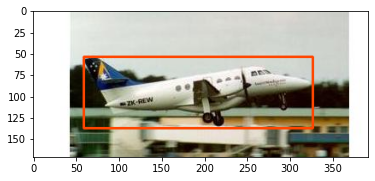

In [3]:
img_idx=random.randint(0, len(os.listdir("airplanes_images/"))-1)

filename, startX, startY, endX, endY = annot_df.iloc[img_idx]
img = cv2.imread("airplanes/"+filename)
cv2.rectangle(img, (startX, startY), (endX, endY),(0, 70, 255), 2)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

### Data Preprocessing

In [4]:
# Scaling the bounding box coordinates to the range [0, 1]
from tqdm import tqdm

image_dir = "airplanes/"
airplanes = os.listdir(image_dir)

scaled_boxs = []

for i in tqdm(range(len(annot_df))):
    
    filename, startX, startY, endX, endY = annot_df.iloc[i]
    img = cv2.imread(image_dir+filename)
    
    ht, wd = img.shape[:2]
    startX, startY, endX, endY = target_boxs[i]

    startX = float(startX)/wd
    startY = float(startY)/ht
    endX   = float(endX)/wd
    endY   = float(endY)/ht
    
    scaled_boxs.append([startX, startY, endX, endY])
  
scaled_boxs = np.asarray(scaled_boxs)

100%|██████████| 800/800 [00:01<00:00, 651.33it/s]


In [5]:
# Loading images to numpy
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

image_data = []

for i in tqdm(range(len(annot_df))):
    filename = annot_df.iloc[i][0]
    image = load_img(image_dir+filename, target_size=(224, 224))
    image = img_to_array(image)
    
    image_data.append(image)
    
image_data = np.asarray(image_data)

100%|██████████| 800/800 [00:01<00:00, 479.74it/s]


In [27]:
# Train Test Split
from sklearn.model_selection import train_test_split

X = image_data
y = scaled_boxs

X_train, X_test ,y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

print("X_train shape ", X_train.shape)
print("y_train shape ", y_train.shape)

X_train shape  (720, 224, 224, 3)
y_train shape  (720, 4)


In [28]:
# Normalizing Images
X_train = X_train/255.0
X_test = X_test/255.0

# Reshaping
print("Before - ",X_train.shape)

# # dim = (batchsize, x(width), y(height), color_channels)
X_train = X_train.reshape(X_train.shape[0], 224,224,3)
X_test  = X_test.reshape(X_test.shape[0], 224,224,3)

print("After - ",X_train.shape)

Before -  (720, 224, 224, 3)
After -  (720, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


idx - 458 : 27 46 197 177


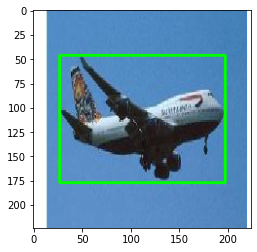

In [30]:
img_idx = random.randint(0, len(X_train)-1)
img = X_train[img_idx]
startX, startY, endX, endY = list(map(int, y_train[img_idx]*224))
print("idx -",img_idx,":",startX, startY, endX, endY)

cv2.rectangle(img, (startX, startY), (endX, endY),(0, 255, 0), 2)
plt.imshow(img)
plt.show()

## BBox Regression Model using TL VGG16

In [45]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam


vgg = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False

# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

opt = Adam(lr=1e-4)
model.compile(loss="mse", optimizer=opt)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [46]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,mode='min', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, verbose=1)
model_chkpt = ModelCheckpoint('airplane_detector2.hdf5',save_best_only=True, monitor='val_loss',mode="auto" ,verbose=1)

callback_list = [model_chkpt,lr_reduce]

In [47]:
model.fit(x=X_train, y=y_train,
          validation_data=(X_test, y_test),
          batch_size=128,epochs=15,
          callbacks=callback_list)

Epoch 1/15
6/6 [==============================] - 58s 5s/step - loss: 0.0091 - val_loss: 0.0049

Epoch 00001: saving model to airplane_detector2.hdf5
Epoch 2/15
6/6 [==============================] - 6s 1s/step - loss: 0.0034 - val_loss: 0.0022

Epoch 00002: saving model to airplane_detector2.hdf5
Epoch 3/15
6/6 [==============================] - 6s 1s/step - loss: 0.0019 - val_loss: 0.0020

Epoch 00003: saving model to airplane_detector2.hdf5
Epoch 4/15
6/6 [==============================] - 6s 1s/step - loss: 0.0013 - val_loss: 0.0019

Epoch 00004: saving model to airplane_detector2.hdf5
Epoch 5/15
6/6 [==============================] - 6s 1s/step - loss: 0.0011 - val_loss: 0.0017

Epoch 00005: saving model to airplane_detector2.hdf5
Epoch 6/15
6/6 [==============================] - 6s 1s/step - loss: 8.9870e-04 - val_loss: 0.0016

Epoch 00006: saving model to airplane_detector2.hdf5
Epoch 7/15
6/6 [==============================] - 6s 1s/step - loss: 7.9368e-04 - val_loss: 0.0016

E

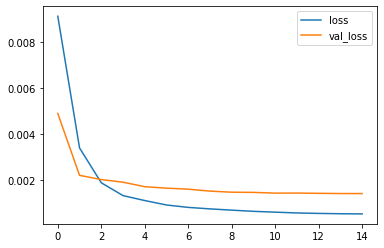

In [48]:
losses = pd.DataFrame(model.history.history)
losses=losses[['loss', 'val_loss']]
losses.plot()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


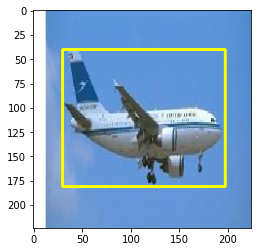

In [50]:
import imutils

img_idx = random.randint(0, len(X_test)-1)
plane = X_test[img_idx].reshape(1, 224,224,3)
bound_box = model.predict(plane)

startX, startY, endX, endY = bound_box[0]

w,h = plane.shape[1:3]

startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)

img = plane[0]
cv2.rectangle(img, (startX, startY), (endX, endY),(255, 70, 0), 2)

plt.imshow(img)
plt.show()

### Input Image

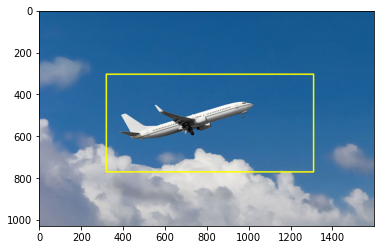

In [51]:
image_idx = random.randint(0,800-1)
image_path = "plane.jpg"#"airplanes/"+os.listdir("airplanes/")[image_idx]

h,w = img_to_array(load_img(image_path)).shape[:2]
image = load_img(image_path, target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)

preds = model.predict(image)[0]
startX, startY, endX, endY = preds
image=image[0]

image = cv2.imread(image_path)
image = imutils.resize(image, width=w, height=h)
#(h, w) = image.shape[:2]

startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)

cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 255), 5)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(image)
plt.show()

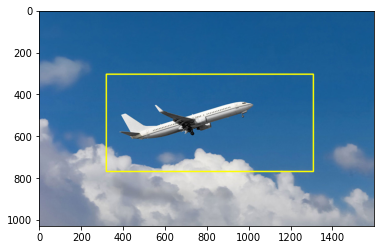

In [52]:
def detect_plane(image_inp):
    h,w = image_inp.shape[:2]
    image = cv2.resize(image_inp, (224, 224))
    image=image/255.0
    image = np.expand_dims(image, axis=0)

    preds = model.predict(image)[0]
    startX, startY, endX, endY = preds
    image=image[0]

    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)

    # print(startX, startY,endX, endY)
    cv2.rectangle(image_inp, (startX, startY), (endX, endY),(255, 255, 0), 5)
    return image_inp


inp = cv2.imread("plane.jpg")
inp = cv2.cvtColor(inp, cv2.COLOR_BGR2RGB)
out= detect_plane(inp)
plt.figure(figsize=(6,6))
plt.imshow(out)
plt.show()

## Object Detection on Video

In [54]:
from moviepy.editor import VideoFileClip

# Where to save the output video
vid_output = 'adet.mp4'
# Location of the input video
clip1 = VideoFileClip("planevid2.mp4")
# Create the clip
vid_clip = clip1.fl_image(detect_plane)
vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video adet.mp4
[MoviePy] Writing video adet.mp4


100%|██████████| 534/534 [01:18<00:00,  6.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: adet.mp4 

